<a href="https://colab.research.google.com/github/felixM2020/ecn_t10_scorecard_scraper/blob/main/t10_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#T10 Data Analysis

###Main question: 
Should a bowling team focus more on defensive or offensive bowling? In other terms, should they prioritise minimising the run rate or maximising the wickets taken?

##Data Cleaning and Transformation


In [22]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/t10_ecn_bowling.csv')
df = df.sort_values(by = 'O', axis = 0, ascending = False)
df.head()

,Unnamed: 0,Team,Opponent,Date,Result,Bowling,O,M,R,W,NB,WD,E/R
372,0,Finland,England XI,| Thursday 30th September | 07:00,England XI beat Finland by 14 runs,Rich Edwards,2.0,0,27,1,0,2,13.5
847,5,Sweden,Norway,| Friday 17th September | 07:00,Sweden beat Norway by 22 runs,Abhijit Venkatesh (c),2.0,0,24,0,0,0,12.0
845,3,Sweden,Norway,| Friday 17th September | 07:00,Sweden beat Norway by 22 runs,Oktai Gholami,2.0,0,23,4,1,1,11.5
484,3,Italy,England XI,| Tuesday 28th September | 09:00,England XI beat Italy by 33 runs,Max Uttley,2.0,0,32,0,0,1,16.0
844,2,Sweden,Norway,| Friday 17th September | 07:00,Sweden beat Norway by 22 runs,Azam Khalil,2.0,0,29,1,0,0,14.5


Cleaning objectives: 

*   Change overs to (legal) balls bowled
*   Change Result to whether bowler's team won
*   Change team names to single string (eg: get rid of XI)
*   Turn Date into Datetime







### Transform Balls bowled

In [23]:
def overs_to_balls(value):
  value = str(value).strip()
  sides = value.split('.')
  overs = sides[0]
  balls = sides[1]
  out = int(balls) + (int(overs) * 6)
  return out

df['Balls'] = df['O'].apply(overs_to_balls)
df = df.drop(['O'], axis = 1)
df.head()

,Unnamed: 0,Team,Opponent,Date,Result,Bowling,M,R,W,NB,WD,E/R,Balls
372,0,Finland,England XI,| Thursday 30th September | 07:00,England XI beat Finland by 14 runs,Rich Edwards,0,27,1,0,2,13.5,12
847,5,Sweden,Norway,| Friday 17th September | 07:00,Sweden beat Norway by 22 runs,Abhijit Venkatesh (c),0,24,0,0,0,12.0,12
845,3,Sweden,Norway,| Friday 17th September | 07:00,Sweden beat Norway by 22 runs,Oktai Gholami,0,23,4,1,1,11.5,12
484,3,Italy,England XI,| Tuesday 28th September | 09:00,England XI beat Italy by 33 runs,Max Uttley,0,32,0,0,1,16.0,12
844,2,Sweden,Norway,| Friday 17th September | 07:00,Sweden beat Norway by 22 runs,Azam Khalil,0,29,1,0,0,14.5,12


Change result to whether the bowler's team won

In [24]:
pd.unique(df['Result'])[:10]

array(['England XI beat Finland by 14 runs',
       'Sweden beat Norway by 22 runs',
       'England XI beat Italy by 33 runs',
       'Belgium beat Spain by 6 wickets',
       'England XI beat Finland by 9 wickets',
       'Spain beat Sweden by 13 runs',
       'Czech Republic beat Italy by 8 wickets',
       'Italy beat Germany by 35 runs', 'Spain beat Belgium by 7 wickets',
       'Finland beat Italy by 5 runs'], dtype=object)

All result strings begin with the winning team.

Add win and bat_first columns

In [25]:
def winning_team(result_string):
  team = result_string.split('beat')[0]
  return team.strip()

def winning_team_bat_first(result_string):
  win_by = result_string.strip().split(' ')[-1]
  return win_by == 'runs'

def bowler_team_result(row):
  result_string = row['Result'] 
  team = row['Team']
  winners = winning_team(result_string)
  return team == winners

df['Win'] = df.apply(bowler_team_result, axis = 1)

def bat_first_innings(row):
  result_string = row['Result'] 
  win = row['Win']
  winners_bat_first = winning_team_bat_first(result_string)
  return win == winners_bat_first
  
df['Bat_First'] = df.apply(bat_first_innings, axis=1)
df = df.drop(['Result'], axis = 1)
df.head()


,Unnamed: 0,Team,Opponent,Date,Bowling,M,R,W,NB,WD,E/R,Balls,Win,Bat_First
372,0,Finland,England XI,| Thursday 30th September | 07:00,Rich Edwards,0,27,1,0,2,13.5,12,False,False
847,5,Sweden,Norway,| Friday 17th September | 07:00,Abhijit Venkatesh (c),0,24,0,0,0,12.0,12,True,True
845,3,Sweden,Norway,| Friday 17th September | 07:00,Oktai Gholami,0,23,4,1,1,11.5,12,True,True
484,3,Italy,England XI,| Tuesday 28th September | 09:00,Max Uttley,0,32,0,0,1,16.0,12,False,False
844,2,Sweden,Norway,| Friday 17th September | 07:00,Azam Khalil,0,29,1,0,0,14.5,12,True,True


Clean date column

In [26]:
from datetime import datetime

months = {'January': 1,'February': 2,'March': 3,
        'April':4,'May':5,'June':6,
         'July':7,'August':8,'September':9,
         'October':10,'November':11,'December':12}

def parse_day(string):
  if string[:2].isdigit():
    return int(string[:2])
  return int(string[:1])

#datetime(year, month, day, hour, minute, second, microsecond)
def get_datetime(time_string):
  time_string = time_string.replace('| ', '')
  time_string = time_string.strip()
  splits = time_string.split(' ')
  time = splits[-1]
  year = 2021
  month = months[splits[2]]
  day = parse_day(splits[1])
  hour_split = time.split(':')
  hour = int(hour_split[0])
  minute = int(hour_split[1])
  second = 0
  microsecond = 0
  return datetime(year, month, day, hour, minute, second, microsecond)


df['Date'] = df['Date'].apply(get_datetime)
df.head()

,Unnamed: 0,Team,Opponent,Date,Bowling,M,R,W,NB,WD,E/R,Balls,Win,Bat_First
372,0,Finland,England XI,2021-09-30 07:00:00,Rich Edwards,0,27,1,0,2,13.5,12,False,False
847,5,Sweden,Norway,2021-09-17 07:00:00,Abhijit Venkatesh (c),0,24,0,0,0,12.0,12,True,True
845,3,Sweden,Norway,2021-09-17 07:00:00,Oktai Gholami,0,23,4,1,1,11.5,12,True,True
484,3,Italy,England XI,2021-09-28 09:00:00,Max Uttley,0,32,0,0,1,16.0,12,False,False
844,2,Sweden,Norway,2021-09-17 07:00:00,Azam Khalil,0,29,1,0,0,14.5,12,True,True


##Analyse Data

###Import Packages

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

Visualise Runs against and Wickets Taken in Wins vs Losses

In [28]:
df.dtypes

Unnamed: 0             int64
Team                  object
Opponent              object
Date          datetime64[ns]
Bowling               object
M                      int64
R                      int64
W                      int64
NB                     int64
WD                     int64
E/R                  float64
Balls                  int64
Win                     bool
Bat_First               bool
dtype: object

Summarise into Team stats

In [29]:
team_results = df.loc[:,['Team', 'Win', 'Date', 'Opponent']].drop_duplicates(keep = 'first')
team_wins = team_results.loc[:,['Team', 'Win']].groupby('Team').apply(
    lambda x: x['Win'].sum()/len(x)).sort_index()
print(team_wins)

team_runs = df.loc[:,['Team', 'R']].groupby('Team').sum()
team_wickets = df.loc[:,['Team', 'W']].groupby('Team').sum()
team_balls = df.loc[:,['Team', 'Balls']].groupby('Team').sum()
team_runs['R'] = team_runs['R'] / team_balls['Balls']
team_runs = team_runs.sort_values(by = 'Team')
team_wickets['W'] = team_wickets['W'] /team_balls['Balls']
team_wickets = team_wickets.sort_values(by = 'Team')



team_stats = pd.concat([team_wins, team_wickets, team_runs], axis = 1)
team_stats.rename(columns = {team_stats.columns[0]: 'Win Percentage'}, inplace = True)
team_stats


Team
Austria           0.562500
Belgium           0.600000
Czech Republic    0.333333
England XI        0.894737
Finland           0.125000
Germany           0.500000
Hungary           0.333333
Italy             0.470588
Luxembourg        0.000000
Netherlands XI    0.666667
Norway            0.500000
Portugal          0.300000
Romania           0.250000
Spain             0.500000
Sweden            0.555556
dtype: float64


,Win Percentage,W,R
Team,,,
Austria,0.562500,0.092857,1.963095
Belgium,0.600000,0.093067,2.030389
Czech Republic,0.333333,0.077263,1.750552
England XI,0.894737,0.081950,1.921162
Finland,0.125000,0.100962,1.776442
Germany,0.500000,0.105364,1.674330
Hungary,0.333333,0.097959,1.889796
Italy,0.470588,0.085714,1.772527
Luxembourg,0.000000,0.066434,1.846154


Visualise Team Stats

                Win Percentage         R
Win Percentage        1.000000  0.244313
R                     0.244313  1.000000
                Win Percentage         W
Win Percentage        1.000000  0.239536
W                     0.239536  1.000000


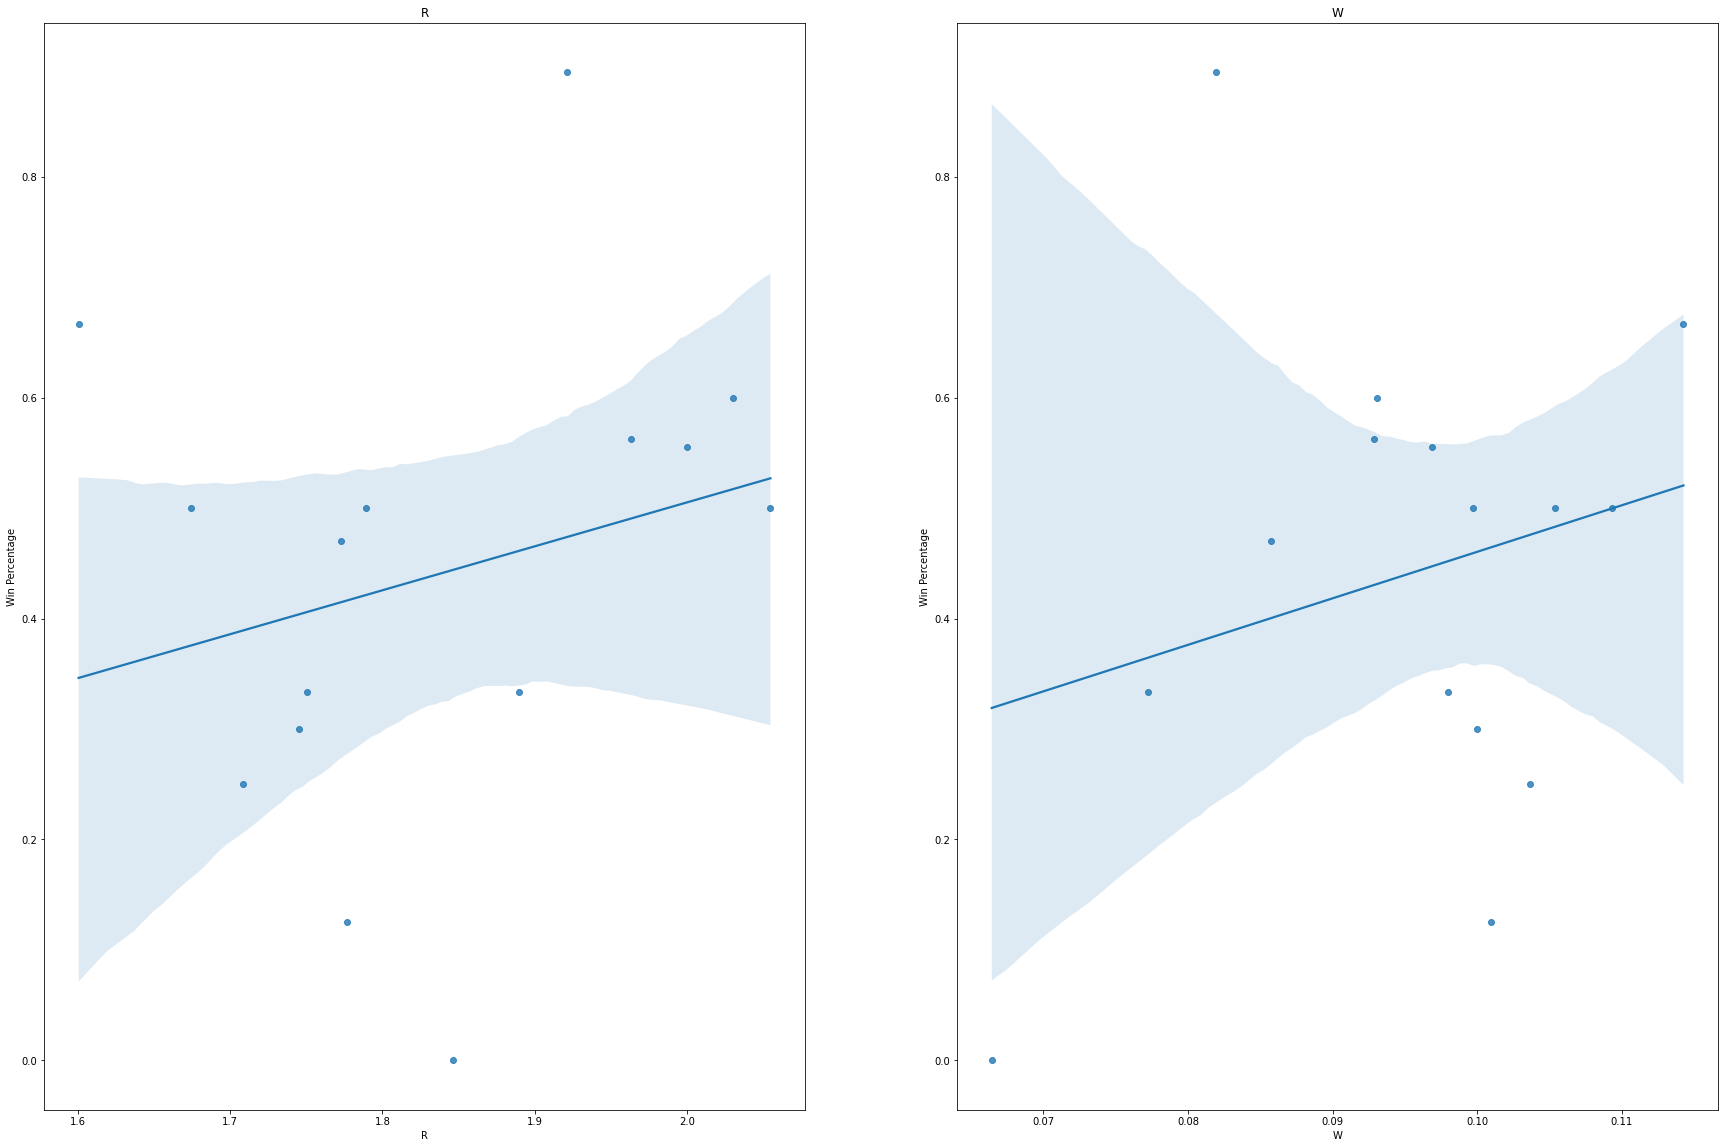

In [30]:
fig, axes = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (30, 20)
cols = ['R','W']
for i in range(len(cols)):
  col = cols[i]
  corr = team_stats.loc[:,['Win Percentage', col]].corr(method= 'pearson')
  print(corr)
  sns.regplot(ax = axes[i], data = team_stats, x = col, y = 'Win Percentage')
  #axes[i].text(20, 29.5, corr, fontsize = 11, style = 'italic', horizontalalignment='center',    verticalalignment='center')
  axes[i].set_title(col)
plt.show()

Little to no correlation on the team aggregate level between win percentage and either runs or wickets per ball.

This time we will analyse whether correlation is any different when we divide the data into batting first and bowling first.

Prepare Data

In [31]:
dfs = []
bat_first = [True, False]
for i in range(2):
  data = df[df['Bat_First'] == bat_first[i]]
  team_results = data.loc[:,['Team', 'Win', 'Date', 'Opponent']].drop_duplicates(keep = 'first')
  team_wins = team_results.loc[:,['Team', 'Win']].groupby('Team').apply(
    lambda x: x['Win'].sum()/len(x)).sort_index()
  print(team_wins)

  team_runs = df.loc[:,['Team', 'R']].groupby('Team').sum()
  team_wickets = df.loc[:,['Team', 'W']].groupby('Team').sum()  
  team_balls = df.loc[:,['Team', 'Balls']].groupby('Team').sum()
  team_runs['R'] = team_runs['R'] / team_balls['Balls']
  team_runs = team_runs.sort_values(by = 'Team')
  team_wickets['W'] = team_wickets['W'] /team_balls['Balls']
  team_wickets = team_wickets.sort_values(by = 'Team')



  team_stats = pd.concat([team_wins, team_wickets, team_runs], axis = 1)
  team_stats.rename(columns = {team_stats.columns[0]: 'Win Percentage'}, inplace = True)
  dfs.append(team_stats)


Team
Austria           0.500000
Belgium           0.444444
Czech Republic    0.200000
England XI        0.750000
Finland           0.200000
Germany           0.400000
Hungary           0.400000
Italy             0.333333
Luxembourg        0.000000
Netherlands XI    0.714286
Norway            0.500000
Portugal          0.500000
Romania           0.500000
Spain             0.500000
Sweden            0.600000
dtype: float64
Team
Austria           0.600000
Belgium           0.727273
Czech Republic    0.500000
England XI        1.000000
Finland           0.000000
Germany           0.600000
Hungary           0.250000
Italy             0.545455
Luxembourg        0.000000
Netherlands XI    0.500000
Norway            0.500000
Portugal          0.000000
Romania           0.000000
Spain             0.500000
Sweden            0.500000
dtype: float64


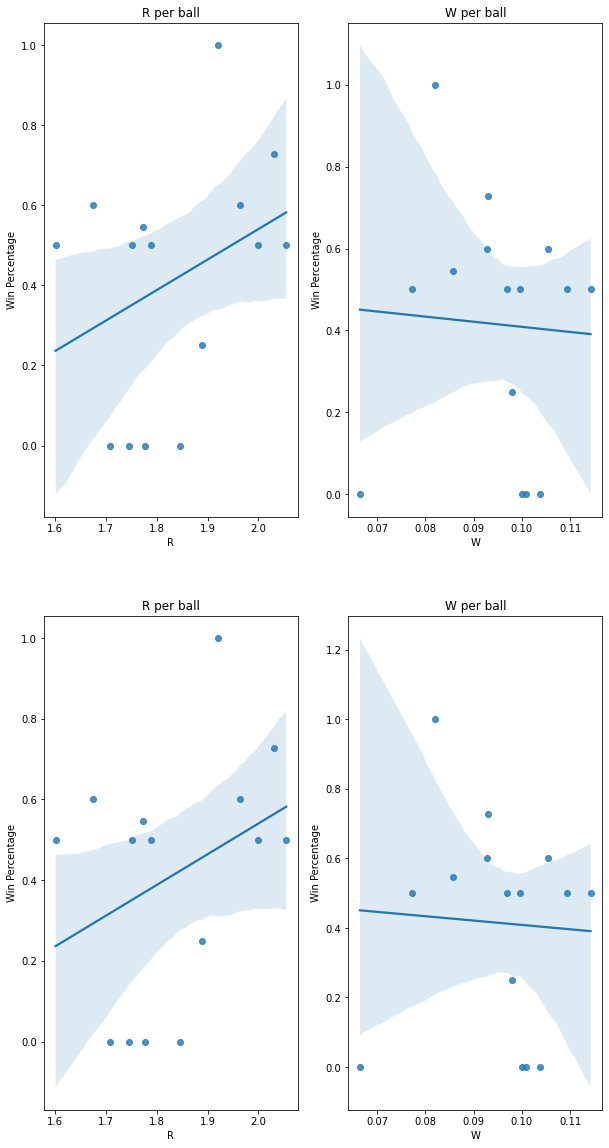

In [32]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10,20)
for i in range(2):
  data = dfs[i]
  cols = ['R','W']
  for c in range(len(cols)):
    col = cols[c]
    corr = team_stats.loc[:,['Win Percentage', col]].corr(method= 'pearson')
    sns.regplot(ax = axes[i, c], data = team_stats, x = col, y = 'Win Percentage')
    #axes[i].text(20, 29.5, corr, fontsize = 11, style = 'italic', horizontalalignment='center',    verticalalignment='center')
    axes[i,c].set_title(col +' per ball')
plt.show()

  

Instead of looking through summarizing teams entirely, let's now group by team outcomes per game and see what the result is. However, because we are now looking at individual games, wins no longer come as a percentage, therefore forcing us to visualise the data differently than a scatter plot.

In [33]:
groups = df[['Team', 'Date', 'Win', 'Bat_First' ,'R', 'W', 'NB', 'WD', 'Balls']].groupby(['Team', 'Date', 'Win', 'Bat_First']).sum()
groups = groups.reset_index()
groups

,Team,Date,Win,Bat_First,R,W,NB,WD,Balls
0,Austria,2021-09-20 07:00:00,True,True,104,8,0,8,60
1,Austria,2021-09-20 13:00:00,True,False,98,3,0,2,53
2,Austria,2021-09-21 09:00:00,False,False,75,10,2,2,50
3,Austria,2021-09-21 13:00:00,True,False,88,2,0,5,38
4,Austria,2021-09-22 07:00:00,False,False,62,9,0,2,60
...,...,...,...,...,...,...,...,...,...
181,Sweden,2021-09-15 15:00:00,False,True,129,6,1,5,52
182,Sweden,2021-09-16 07:00:00,True,False,78,1,0,2,40
183,Sweden,2021-09-16 11:00:00,True,False,150,2,2,4,55
184,Sweden,2021-09-17 07:00:00,True,True,123,7,1,5,60


Visualise data in same way as before

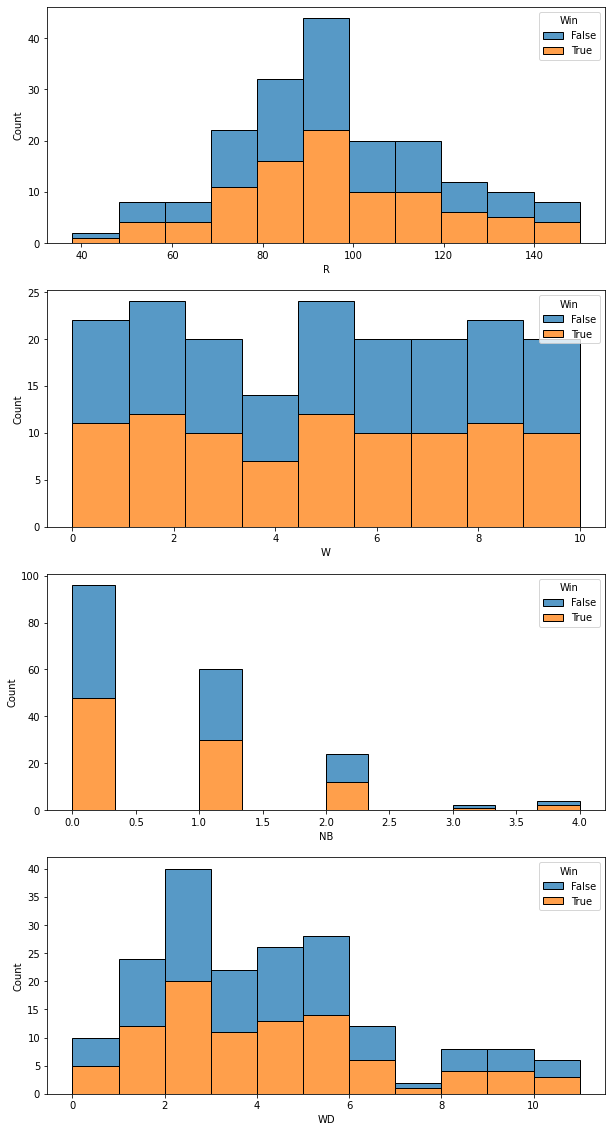

In [34]:
fig, ax = plt.subplots(4,1)
fig.set_size_inches(10,20)
cols = ['R', 'W', 'NB', 'WD']
for i in range(len(cols)):
  col = cols[i]
  sns.histplot(ax = ax[i], data = groups, multiple = 'stack',  x = col, hue = 'Win' )
plt.show()


##Perform and Train Machine Learning on Data

###Prepare Data

In [35]:
team_games = groups
team_games['Win'] = team_games['Win'].apply(lambda x:  1 if x else 0)
team_games['Bat_First'] = team_games['Bat_First'].apply(lambda x:  1 if x else -1)

team_games['Day_f_start'] = team_games['Date'].apply(lambda x: (x - datetime(2021, 9, 13)).days)
team_games['Start_Time'] = team_games['Date'].apply(lambda x: x.hour)
team_games.drop(['Team', 'Date'], axis = 1, inplace = True)
for col in team_games.columns:
  team_games[col] = team_games[col].apply(lambda x  : float(x))

###Import Modules

In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split


###Create Model Structure

In [37]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        #flatten image to vector
        #Use ReLU
        next = F.relu(self.fc1(x))
       
        
        return self.fc2(next)
    
model = Net()
print(model)   



Net(
  (fc1): Linear(in_features=8, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)


###Load Data

In [38]:

# Creating np arrays
train, test = train_test_split(team_games, test_size=0.3)
out = []
for t in [train,test]:
  target = np.array(t['Win'].values)
  target_t = torch.tensor(target)
  torch.reshape(target_t, (1, len(target)))
  features = np.array(t.drop('Win', axis=1).values)
  features_t = torch.tensor(features)
  tens = torch.utils.data.TensorDataset(target_t, features_t)
  out.append(tens)


# Passing to DataLoader
train_loader = torch.utils.data.DataLoader(out[0], shuffle=True)
test_loader = torch.utils.data.DataLoader(out[1], shuffle=False, batch_size = 60)

### Define Optimization Criteria

In [39]:

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


##Perform Training

In [40]:
# Iterate through train set minibatchs 
for  labels, games  in tqdm(train_loader):

    # Zero out the gradients
    optimizer.zero_grad()
    # Forward pass
    x = games
    y = model(x.float())
    loss = criterion(y, labels.long())
    # Backward pass
    loss.backward()
    optimizer.step()

    
## Testing
correct = 0
total = len(test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for  labels, games in tqdm(test_loader):
        # Forward pass
        x = games
        y = model(x.float())
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Test accuracy: 0.4821428656578064


###Very Innacurate for testing data, implying either more data needed 